# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [3]:
using Turing
using Distances
using LinearAlgebra
using LimberJack

In [4]:
using Interpolations
using GaussianProcess
using Plots
using QuadGK

In [5]:
zlat = range(0, 2.5, length=24);
cosmo1 = Cosmology();
H1 = cosmo1.cpar.h*100*Ez(cosmo1, zlat);

### 1. Collate Hz and Dm data

#### Hz data

In [6]:
function CC()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "CC",
        z = z,
        data = data,
        cov = cov
    )
end


CC (generic function with 1 method)

In [7]:
function BOSSDR12()
    z = [0.38, 0.51, 0.61]
    data = [81.2087, 90.9029, 98.9647]
    cov = [5.00049e+02 2.94536e+02 1.42011e+02; 2.94536e+02 7.02299e+02 4.32750e+02; 1.42011e+02 4.32750e+02 1.01718e+03]
    return (data_name = "BOSSDR12", z = z, data = data, cov = cov)
end

BOSSDR12 (generic function with 1 method)

#### Dm data

In [8]:
#function BOSSDR12_dm()
    #z = [0.38, 0.51, 0.61]
    #data = [1512.39, 1975.22, 2306.68]
    #cov = [3.63049e+00 1.80306e+00 9.19842e-01; 1.80306e+00 3.77146e+00 2.21471e+00; 9.19842e-01 2.21471e+00 4.37982e+00]
    #return (data_name = "BOSSDR12_dm", z = z, data = data, cov = cov)
#end

In [9]:
function BOSSDR12_dm()
    z = [2.1, 2.2, 2.3]
    data = comoving_radial_distance(cosmo1, z)
    err = 0.1*data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "BOSSDR12_dm", z = z, data = data, cov = cov)
end

BOSSDR12_dm (generic function with 1 method)

#### Putting Hz and Dm together

In [10]:
cc = CC();
bossdr12 = BOSSDR12();
bossdr12dm = BOSSDR12_dm();

In [11]:
# observed data 
observations  = [bossdr12.data; cc.data; bossdr12dm.data];
z_obs = [bossdr12.z; cc.z; bossdr12dm.z];

In [12]:
# observed covariance
covariance_obs = zeros(length(bossdr12.data)+ length(cc.data)+ length(bossdr12dm.data), 
length(bossdr12.data)+ length(cc.data)+ length(bossdr12dm.data));
for i in 1:length(bossdr12.data)
    for j in 1:length(bossdr12.data)
        covariance_obs[i,j] = bossdr12.cov[i,j]
    end
end

for i in 1:length(cc.data)
    for j in 1:length(cc.data)
        covariance_obs[i+length(bossdr12.data), j+length(bossdr12.data)] = cc.cov[i,j]
    end
end

for i in 1:length(bossdr12dm.data)
    for j in 1:length(bossdr12dm.data)
        covariance_obs[i+length(bossdr12.data)+length(bossdr12dm.data), j+length(bossdr12.data)+length(bossdr12dm.data)] = cc.cov[i,j]
    end
end


In [13]:
omegam = 0.3
omegab = 0.05
hc = 0.67

0.67

### 2. Check what our priors look like

In [14]:
function model_latent_GP(eta, l, v;  
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hx = cpar.h*100*Ez(cpar, x)
    hx = latent_GP(mean_hx, v, kernel)
    # transforms from latent variable space to observation space
    hz =  conditional(x, z, hx, sqexp_cov_fn;
                     eta=eta, l=l)
    return hx, hz
end

model_latent_GP (generic function with 1 method)

In [15]:
z_integ = Vector(0:0.05:2.5);

In [16]:
N_samples = 100
hxs=zeros(N_samples, 24)
hzs=zeros(N_samples, length(z_integ))
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    hxs[i, :], hzs[i, :] = model_latent_GP(eta, l, v; z=z_integ)
end

y_m, y_s = mean(hzs, dims=1), std(hzs, dims=1);
gp_m, gp_s = mean(hxs, dims=1), std(hxs, dims=1);

# interpolated Hz data
hz_itp = linear_interpolation(z_integ, vec(y_m));
#hz_itp_data = hz_itp(z_obs)


51-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
  66.36752567898691
  69.00600699603747
  69.95540043546431
  71.31532257915434
  73.64093255463152
  76.07219596352849
  78.27057641477596
  80.51964154555083
  83.07897322640866
  85.76419742731629
   ⋮
 207.99808584116556
 212.6304376858231
 217.90450959443183
 222.8098924461447
 226.51569647055751
 230.60295376712125
 238.14307735736773
 246.70437849308396
 247.07399244899312

In [17]:

println(typeof(hxs))
println(size(z_integ))
println(hz_itp(0.39))
println(hz_itp(0.65))
println(typeof(hz_itp))


Matrix{Float64}
(51,)
82.5671068902371
96.29149332035749
Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Gridded{Linear{Throw{OnGrid}}}, Tuple{Vector{Float64}}}, Gridded{Linear{Throw{OnGrid}}}, Throw{Nothing}}


In [18]:
function comoving_d(zs, hz_itp)
    chis = zeros(Real, length(zs))
    for i in 1:length(zs)
        zz = zs[i]
        chis[i] = quadgk(z -> 1.0/hz_itp(z), 0.0, zz, rtol=1E-5)[1]
        #chis[i] = quadgk(z -> 1.0/Ez(cpar, z), 0.0, zz, rtol=1E-5)[1]
        #chis[i] *= CLIGHT_HMPC / cpar.h
        chis[i] *= 300000


    end
    chii = linear_interpolation(zs, vec(chis), extrapolation_bc=Line())
    return chii
end


comoving_d (generic function with 1 method)

In [19]:
chiitp = comoving_d(z_integ, hz_itp)


51-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Real}, Gridded(Linear())), Line()) with element type Float64:
    0.0
  221.63711784355667
  437.52775495482007
  649.8925949275894
  856.8692883342071
 1057.2718212859975
 1251.659910580417
 1440.596783065483
 1623.988792367213
 1801.6766429769405
    ⋮
 5553.929172563879
 5625.269417305419
 5694.928569405231
 5763.00056157411
 5829.789109730991
 5895.436837747029
 5959.450381079146
 6021.325425377668
 6082.053333759249

In [ ]:

println(chiitp(0.65))
println(bossdr12dm.data)
println(chiitp(z_integ))

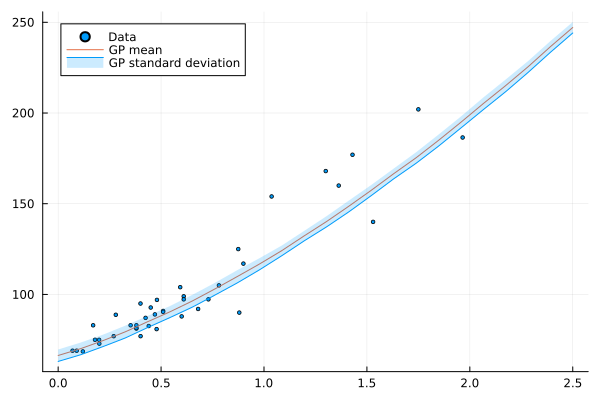

In [20]:
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(zlat, vec(gp_m), label="GP mean")
plot!(zlat, vec(gp_m .- gp_s),  fillrange = vec(gp_m .+ gp_s), fillalpha=0.2, c=1, label="GP standard deviation")

In [21]:
println(length(vec(y_m)))

51


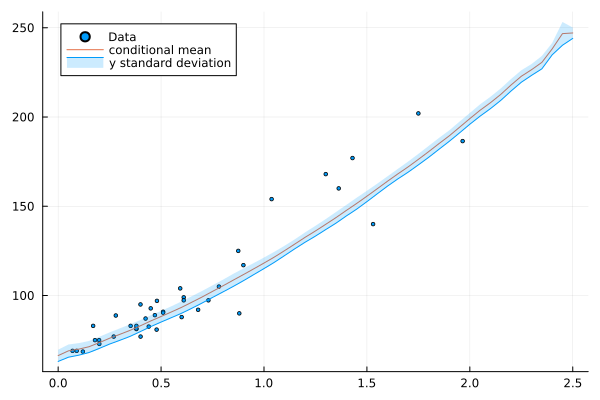

In [22]:
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(z_integ, vec(y_m), label="conditional mean")
plot!(z_integ, vec(y_m .- y_s),  fillrange = vec(y_m .+ y_s), fillalpha=0.2, c=1, label="y standard deviation")

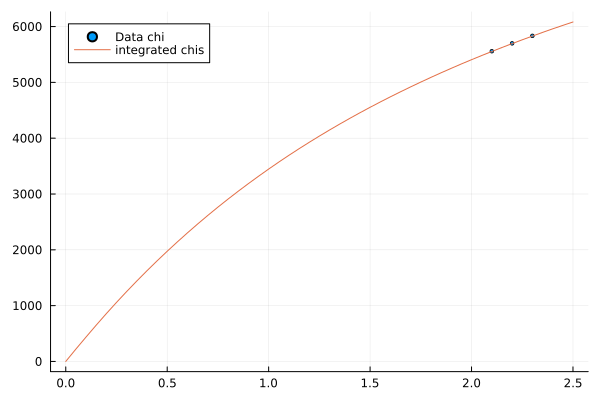

In [23]:
plot(z_obs[41:43], observations[41:43], label="Data chi", ms=2, seriestype=:scatter)
chicont = comoving_radial_distance(cosmo1, zlat)
#plot!(zlat, chicont)
plot!(z_integ, chiitp(z_integ), label="integrated chis")
#plot!(zlat, vec(y_m .- y_s),  fillrange = vec(y_m .+ y_s), fillalpha=0.2, c=1, label="chi standard deviation")

### 3. Define our statistical model

In [24]:
cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
mean_hz = cpar.h*100*Ez(cpar, zlat)
eta2=10
l2=0.02
cov_fn = sqexp_cov_fn(zlat; eta=eta2,l=l2)
v2 = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
hgp = latent_GP(mean_hz, v2, cov_fn)

H_int = conditional(zlat, z_integ, mean_hz, sqexp_cov_fn; eta=eta2, l=l2)
H_int_grid = linear_interpolation(z_integ, H_int)
chi_interp = comoving_d(z_integ, H_int_grid)

hdata = H_int_grid(z_obs[1:40])
chidata = chi_interp(z_obs[41:43])

println([hdata;chidata])
println(typeof(chidata))
println(typeof(hdata))
#y ~ MvNormal([hdata; chidata], data_cov)


[81.6712851471371, 88.2715065085428, 93.57864806382213, 69.80956095537371, 70.19217867926515, 70.91496321739338, 72.55852953440514, 72.93938829563724, 73.78574109837525, 73.82805873851215, 76.97371935933587, 77.39027386098213, 80.36508128917507, 81.6712851471371, 81.68061517469397, 82.60428790282427, 82.62488002784508, 83.8758516228591, 84.66350040490498, 85.16285943665955, 86.21113304466397, 86.6397572930731, 86.72754780178339, 88.2715065085428, 92.62660005210876, 93.00274045709446, 93.57864806382213, 97.66032383944683, 100.62574616822693, 103.69260934286784, 109.66644353645356, 109.99522427943366, 111.3103472513541, 120.52499175809297, 139.77441236501068, 144.6978495480039, 149.91120941950658, 158.03768489717044, 176.6051815658019, 195.70786381850374, 5559.453782189961, 5700.513908843046, 5835.355506514318]
Vector{Float64}
Vector{Float64}


In [25]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors.
    eta2 ~ 200*Uniform(0.0, 0.1)
    l2 ~ 0.02*Uniform(0.1, 3)
    v2 ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hz = cpar.h*100*Ez(cpar, X)
    #h_gp = latent_GP(mean_hz, v2, kernel)

    H_int = conditional(X, int_grid, mean_hz, sqexp_cov_fn; eta=eta2, l=l2)
    H_int_grid = linear_interpolation(int_grid, H_int)
    chi_interp = comoving_d(int_grid, H_int_grid)

    #H_integral_grid = (linear_interpolation(X, mean_hz))(z_integ)
    #chi_interp = (comoving_d(int_grid, linear_interpolation(X, mean_hz)))(z_integ)

    randomvector = range(0,2.5,length=100)

    hdata = H_int_grid(randomvector[1:50])
    chidata = chi_interp(randomvector[51:100])
    datay = [hdata;chidata]

    #m = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    #y ~ MvNormal(datay, data_cov)
    #b ~ MvNormal(datab, data_cov[41:43,41:43])
end

stats_model (generic function with 2 methods)

In [32]:
@model function stats_model2(y; X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors.
    eta2 ~ 200*Uniform(0.0, 0.1)
    l2 ~ 0.02*Uniform(0.1, 3)
    v2 ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hz = cpar.h*100*Ez(cpar, X)
    h_gp = latent_GP(mean_hz, v2, kernel)
    m = conditional(X, data_x[1:40], h_gp, sqexp_cov_fn; eta=eta2, l=l2)
    #H_int_grid = linear_interpolation(int_grid, H_int)
    #chi_interp = comoving_d(int_grid, H_int_grid)

    #hdata = H_int_grid(data_x[1:40])
    #chidata = chi_interp(data_x[41:43])


    y ~ MvNormal(m, data_cov)
    #b ~ MvNormal(chidata, data_cov[41:43,41:43])

    #return y+b??

end

stats_model2 (generic function with 2 methods)

### 4. Sample the model

In [33]:
chain = sample(stats_model2(observations), NUTS(100, 0.65), 1000)

PosDefException: PosDefException: matrix is not positive definite; Factorization failed.

### 5. Check how our posteriors look like

In [ ]:
eta_p = group(chain, :eta2).value.data[:, :, 1];
l_p = group(chain, :l2).value.data[:, :, 1];
v_p = group(chain, :v2).value.data[:, :, 1];

In [ ]:
println(length(v_p))

In [ ]:
N_samples2 = length(eta_p)
gps2=zeros(N_samples2, 24)
ys2=zeros(N_samples2, 100)
for i in 1:N_samples2
    gps2[i, :], ys2[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :];
                                                data_x=LinRange(0, 2.3, 100))
end

y_m2, y_s2 = mean(ys2, dims=1), std(ys2, dims=1);
gp_m2, gp_s2 = mean(gps2, dims=1), std(gps2, dims=1);

In [ ]:
println(y_m2)

In [ ]:
plot(zh, hubble_data, label="Data", ms=2, seriestype=:scatter)
plot!(zcont, H1, label="LCDM", lc=:black)
plot!(LinRange(0, 2.3, 100), vec(y_m2), label="Y mean")
plot!(LinRange(0, 2.3, 100), vec(y_m2 .- y_s2),  fillrange = vec(y_m2 .+ y_s2), fillalpha=0.2, c=1, label="Y standard deviation")


In [ ]:
plot(zh, hubble_data, label="Data", ms=2, seriestype=:scatter)
plot!(zcont, H1, label="LCDM", lc=:black)
plot!(zcont, vec(gp_m2), label="GP mean")
plot!(zcont, vec(gp_m2 .- gp_s2),  fillrange = vec(gp_m2 .+ gp_s2), fillalpha=0.2, c=1, label="GP standard deviation")